## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2 ×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import Tensor as tensor
from dlc_practical_prologue import generate_pair_sets

from torchsummary import summary

import matplotlib.pyplot as plt


## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000
train_input, train_target, train_class, test_input, test_target, test_class = generate_pair_sets(N)

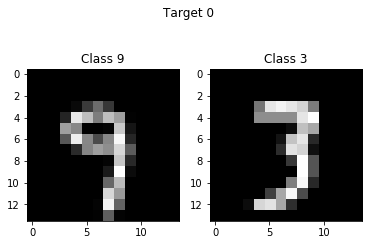

In [3]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Class {train_class[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Class {train_class[0][1].item()}")
fig.suptitle(f"Target {train_target[0].item()}")

plt.show()

In [4]:
# Data loaders
batch_size = 100
train_loader = DataLoader(list(zip(train_input, train_target, train_class)), batch_size)
test_loader = DataLoader(list(zip(test_input, test_target, test_class)), batch_size)

In [5]:
for i in train_loader:
    print(i[0].size())

torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])
torch.Size([100, 2, 14, 14])


### Helpfer Functions

In [106]:
def calc_accuracy(model, data_loader, auxiliary_loss):
    correct = 0
    correct_digit = 0
    total = 0
    
    for (image, target, digit_target) in data_loader:
        total += len(target)
        if not auxiliary_loss:
            output = model(image)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            return correct / total
        else:
            digit1, digit2, output = model(image)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            _, pred1 = torch.max(digit1, 1)
            correct_digit += (pred1 == digit_target[:,0]).sum().item()
            _, pred2 = torch.max(digit2, 1)
            correct_digit += (pred2 == digit_target[:,1]).sum().item()
            
        return correct / total, correct_digit/ 2 / total


def train(train_data_loader, test_data_loader,
          model, optimizer, criterion, AL_weight = 0.5,
          epochs=10, test_every=1, auxiliary_loss = False):
    
    losses = []
    accuracy_train = []
    accuracy_test = []
    accuracy_train_digit = []
    accuracy_test_digit = []
    
    for epoch in range(epochs):
        step = 0
        
        for (image, target, digit_target) in train_data_loader:
            step += 1
#             model.train()
            optimizer.zero_grad()
            if auxiliary_loss:
                digit1,digit2,output = model(image)
                loss = criterion(output, target)
                loss += AL_weight*criterion(digit1, digit_target[:,0])
                loss += AL_weight*criterion(digit2, digit_target[:,1])

            else:
                output = model(image)
                loss = criterion(output, target)
                
            loss.backward()
            optimizer.step()
            
            if step % test_every == 0:
                losses.append(loss)
                
                model.eval()
                with torch.no_grad():
                    accuracy_train_data = calc_accuracy(model, train_data_loader, auxiliary_loss)
                    accuracy_test_data = calc_accuracy(model, test_data_loader, auxiliary_loss)
                    if auxiliary_loss:
                        acc_train, acc_train_digit = accuracy_train_data
                        acc_test, acc_test_digit = accuracy_test_data
                        
                        accuracy_train_digit.append(acc_train_digit)
                        accuracy_test_digit.append(acc_test_digit)
                    else:
                        acc_train = accuracy_train_data
                        acc_test = accuracy_test_data
                        
                    accuracy_train.append(acc_train)
                    accuracy_test.append(acc_test)

                print(f"Epoch {epoch + 1}/{epochs}, Step {step}, loss {losses[-1]:0.4f},",
                      f"train accuracy {accuracy_train[-1]}, test accuracy {accuracy_test[-1]}",
                      f"train accuracy digit {accuracy_train_digit[-1]}, test accuracy digit {accuracy_test_digit[-1]}"
                      if accuracy_train_digit else "")
    if auxiliary_loss:
        return accuracy_train, accuracy_test, losses, accuracy_train_digit, accuracy_test_digit
    else:
        return accuracy_train, accuracy_test, losses
        
def plot_train_info(train_info, auxiliary_loss):
    if auxiliary_loss:
        accuracy_train, accuracy_test, losses, acc_train_digit, acc_test_digit = train_info
    else:
        accuracy_train, accuracy_test, losses = train_info
    fig, ax1 = plt.subplots()

    color_tr = 'tab:green'
    color_te = 'tab:blue'
    color_trd = 'tab:orange'
    color_ted = 'tab:purple'
    ax1.set_xlabel("Step")
    ax1.plot(range(len(accuracy_train)), accuracy_train, color=color_tr)
    ax1.plot(range(len(accuracy_test)), accuracy_test, color=color_te)
    if auxiliary_loss:
        ax1.plot(range(len(acc_train_digit)), acc_train_digit, color=color_trd)
        ax1.plot(range(len(acc_test_digit)), acc_test_digit, color=color_ted)
        ax1.set_ylabel("Accuracy")
        ax1.legend(['Train - Green','Test-Blue', 'Train_Aux - Orange', 'Test_Aux - Purple'])

    else:
        ax1.set_ylabel("Accuracy")
        ax1.legend(['Train - Green','Test-Blue'])
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.legend(['Loss'])
    color_loss = 'tab:red'
    ax2.set_ylabel("Loss", color=color_loss)  # we already handled the x-label with ax1
    ax2.plot(range(len(losses)), losses, color=color_loss)
    ax2.tick_params(axis='y', labelcolor=color_loss)

    fig.tight_layout()
    plt.grid()
    plt.show()
    

## Model

In [35]:
nb_channels = 2 # input channel
nb_digits = 10 # number of digit classes
nb_class = 2 # number of output classes

cross_entropy = nn.CrossEntropyLoss()


### CNN model

In [17]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_channels, auxiliary_loss):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 3) 
        self.conv1_aux = nn.Conv2d(1, 32, 3) 

        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(32, 64, 3) # auxiliary loss flows through this layer of primary objective
        self.fc1 = nn.Linear(64 * 2 * 2, 50)
        self.fc1_aux = nn.Linear(64 * 2 * 2, 50) 
        self.fc2 = nn.Linear(50, 2) #output
        self.fc2_aux = nn.Linear(50, 10)#output
        
        self.subCNN = nn.Sequential(self.conv1, nn.ReLU(), self.pool, self.conv2, nn.ReLU(), self.pool)
        self.subCNN_aux = nn.Sequential(self.conv1_aux, nn.ReLU(), self.pool, self.conv2, nn.ReLU(), self.pool)
        
        self.FC = nn.Sequential(self.fc1, nn.ReLU(), self.fc2)
        self.FC_aux = nn.Sequential(self.fc1_aux, nn.ReLU(), self.fc2_aux)
        
    def forward(self, x):
        input =  x
        x = self.subCNN(x)
        x = x.view(-1, 64 * 2 * 2)
        output = self.FC(x)

        if auxiliary_loss:
            y1 = torch.unsqueeze(input[:,0],dim=1)
            y2 = torch.unsqueeze(input[:,1],dim=1)
            y1 = self.subCNN_aux(y1)
            y2 = self.subCNN_aux(y2)  
            y1 = y1.view(-1, 64 * 2 * 2)
            y2 = y2.view(-1, 64 * 2 * 2)       
            y1 = self.FC_aux(y1)
            y2 = self.FC_aux(y2)
            return y1, y2, output
        else:
            return output

        
    def predict(self, output_class):
        _, predicted_class = torch.max(output_class, 1)
        return predicted_class

In [18]:
CNN_model = CNN(nb_channels, nb_class, auxiliary_loss = True)
summary(CNN_model, input_size=(2, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 12, 12]             608
            Conv2d-2           [-1, 32, 12, 12]             608
              ReLU-3           [-1, 32, 12, 12]               0
         MaxPool2d-4             [-1, 32, 6, 6]               0
         MaxPool2d-5             [-1, 32, 6, 6]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
            Conv2d-8             [-1, 64, 4, 4]          18,496
            Conv2d-9             [-1, 64, 4, 4]          18,496
             ReLU-10             [-1, 64, 4, 4]               0
        MaxPool2d-11             [-1, 64, 2, 2]               0
        MaxPool2d-12             [-1, 64, 2, 2]               0
        MaxPool2d-13             [-1, 64, 2, 2]               0
           Linear-14                   

In [93]:
reg = 0.5
lr = 0.0005# Add learning rate decay
epochs = 25
auxiliary_loss = False
AL_weight = 0.5 # aux loss weight

net = CNN(nb_channels, nb_class, auxiliary_loss)
train_info = train(train_loader, test_loader,
                 model=net,
                 optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
                 criterion=cross_entropy, AL_weight = AL_weight,
                 epochs=epochs, test_every=5, auxiliary_loss = auxiliary_loss)


Epoch 1/25, Step 5, loss 2.5531, train accuracy 0.42, test accuracy 0.47 
Epoch 1/25, Step 10, loss 1.2234, train accuracy 0.65, test accuracy 0.6 
Epoch 2/25, Step 5, loss 0.8064, train accuracy 0.65, test accuracy 0.7 
Epoch 2/25, Step 10, loss 0.6318, train accuracy 0.67, test accuracy 0.69 
Epoch 3/25, Step 5, loss 0.4991, train accuracy 0.69, test accuracy 0.72 
Epoch 3/25, Step 10, loss 0.5137, train accuracy 0.72, test accuracy 0.72 
Epoch 4/25, Step 5, loss 0.4296, train accuracy 0.75, test accuracy 0.74 
Epoch 4/25, Step 10, loss 0.4649, train accuracy 0.75, test accuracy 0.78 
Epoch 5/25, Step 5, loss 0.3964, train accuracy 0.77, test accuracy 0.74 
Epoch 5/25, Step 10, loss 0.4292, train accuracy 0.75, test accuracy 0.78 
Epoch 6/25, Step 5, loss 0.3848, train accuracy 0.78, test accuracy 0.75 
Epoch 6/25, Step 10, loss 0.4092, train accuracy 0.8, test accuracy 0.78 
Epoch 7/25, Step 5, loss 0.3667, train accuracy 0.78, test accuracy 0.73 
Epoch 7/25, Step 10, loss 0.3937, t

In [94]:
# reg = 0.5
# lr = 0.0005# Add learning rate decay
# epochs = 25
# AL_weight = 0.5

auxiliary_loss = True
net = CNN(nb_channels, nb_class, auxiliary_loss)
train_info_AL = train(train_loader, test_loader,
                 model=net,
                 optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
                 criterion=cross_entropy,AL_weight = AL_weight,
                 epochs=epochs, test_every=5, auxiliary_loss = auxiliary_loss)




Epoch 1/25, Step 5, loss 6.1546, train accuracy 0.6, test accuracy 0.61 train accuracy digit 0.195, test accuracy digit 0.215
Epoch 1/25, Step 10, loss 3.0690, train accuracy 0.52, test accuracy 0.57 train accuracy digit 0.28, test accuracy digit 0.345
Epoch 2/25, Step 5, loss 2.7245, train accuracy 0.6, test accuracy 0.57 train accuracy digit 0.395, test accuracy digit 0.495
Epoch 2/25, Step 10, loss 2.1877, train accuracy 0.6, test accuracy 0.6 train accuracy digit 0.495, test accuracy digit 0.46
Epoch 3/25, Step 5, loss 1.9779, train accuracy 0.66, test accuracy 0.62 train accuracy digit 0.51, test accuracy digit 0.56
Epoch 3/25, Step 10, loss 1.7115, train accuracy 0.65, test accuracy 0.72 train accuracy digit 0.615, test accuracy digit 0.645
Epoch 4/25, Step 5, loss 1.6264, train accuracy 0.7, test accuracy 0.66 train accuracy digit 0.685, test accuracy digit 0.715
Epoch 4/25, Step 10, loss 1.3859, train accuracy 0.65, test accuracy 0.7 train accuracy digit 0.71, test accuracy dig

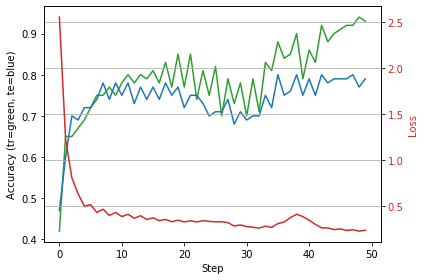

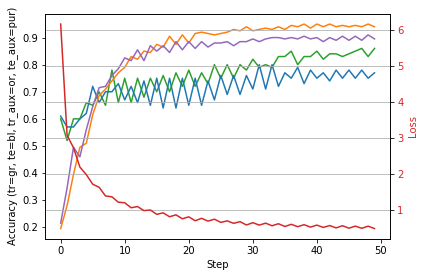

In [95]:
plot_train_info(train_info, False)
plot_train_info(train_info_AL,True)

### Siamese Network

In [84]:
class Siamese(nn.Module):
    def __init__(self, input_channels, output_channels, weight_sharing_CNN, weight_sharing_FC , auxiliary_loss ):

        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  
        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout2d(0.3) 
        self.fc1 = nn.Linear(64 * 2 * 2, 50) 
        self.fc2 = nn.Linear(50, nb_digits) #output
        self.fc3 = nn.Linear(64*2*2*2, 100 )
        self.fc4 = nn.Linear(100, 25)
        self.fc5 = nn.Linear(25, 2)
        self.fc6 = nn.Linear(10*2, 2)
        self.CNNnet1 = nn.Sequential(self.conv1, nn.ReLU(), self.pool, self.dropout, self.conv2, nn.ReLU(), self.pool, self.dropout)
        self.CNNnet2 = nn.Sequential(self.conv1, nn.ReLU(), self.pool, self.dropout, self.conv2, nn.ReLU(), self.pool, self.dropout)
        self.FCnet1 = nn.Sequential(self.fc1, self.fc2)
        self.FCnet2 = nn.Sequential(self.fc1, self.fc2)
        
    def forward(self, x):
        if weight_sharing_CNN == True:
            y1 = self.CNNnet1(torch.unsqueeze(x[:,0],dim=1))
            y2 = self.CNNnet1(torch.unsqueeze(x[:,1],dim=1))
            
        else:
            y1 = self.CNNnet1(torch.unsqueeze(x[:,0],dim=1))
            y2 = self.CNNnet2(torch.unsqueeze(x[:,1],dim=1)) 
            
        y1 = y1.view(-1, 64 *2 *2) 
        y2 = y2.view(-1, 64 *2 *2)
        y = torch.cat((y1, y2), dim = 1)
        if weight_sharing_FC ==True:
            y1 = self.FCnet1(y1)
            #out1 = F.softmax(y1)
            y2 = self.FCnet1(y2)
            #out2 = F.softmax(y2)
            
        else:
            y1 = self.FCnet1(y1)
          #  out1 = F.softmax(y1)
            y2 = self.FCnet2(y2)
           # out2 = F.softmax(y2)
            
       
        y = y.view(-1, 64*2*2*2)
        y = self.fc3(y)
        y = self.fc4(y)
        y = self.fc5(y)
        #y=self.fc6(y)
        if auxiliary_loss == True:
            return y1, y2, y
        else:
            return y

In [67]:
Siamese_model = Siamese(nb_channels, nb_class, True, True, True)
summary(Siamese_model, input_size=(2, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 12, 12]             320
            Conv2d-2           [-1, 32, 12, 12]             320
            Conv2d-3           [-1, 32, 12, 12]             320
              ReLU-4           [-1, 32, 12, 12]               0
         MaxPool2d-5             [-1, 32, 6, 6]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
         MaxPool2d-7             [-1, 32, 6, 6]               0
         Dropout2d-8             [-1, 32, 6, 6]               0
         Dropout2d-9             [-1, 32, 6, 6]               0
        Dropout2d-10             [-1, 32, 6, 6]               0
           Conv2d-11             [-1, 64, 4, 4]          18,496
           Conv2d-12             [-1, 64, 4, 4]          18,496
           Conv2d-13             [-1, 64, 4, 4]          18,496
             ReLU-14             [-1, 6

In [96]:
reg = 0.8
lr = 0.001# Add learning rate decay
epochs = 25
weight_sharing_CNN = False
weight_sharing_FC = False
auxiliary_loss = False
AL_weight = 0.5

net = Siamese(nb_channels, nb_class, weight_sharing_CNN, weight_sharing_FC, auxiliary_loss)

train_info = train(train_loader, test_loader,
                 model=net,
                 optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
                 criterion=cross_entropy, AL_weight = AL_weight,
                 epochs=epochs, test_every=5, auxiliary_loss = auxiliary_loss)


Epoch 1/25, Step 5, loss 4.3542, train accuracy 0.6, test accuracy 0.54 
Epoch 1/25, Step 10, loss 0.7122, train accuracy 0.68, test accuracy 0.76 
Epoch 2/25, Step 5, loss 0.7805, train accuracy 0.65, test accuracy 0.74 
Epoch 2/25, Step 10, loss 0.6066, train accuracy 0.77, test accuracy 0.7 
Epoch 3/25, Step 5, loss 0.5276, train accuracy 0.75, test accuracy 0.74 
Epoch 3/25, Step 10, loss 0.5200, train accuracy 0.75, test accuracy 0.8 
Epoch 4/25, Step 5, loss 0.4650, train accuracy 0.76, test accuracy 0.75 
Epoch 4/25, Step 10, loss 0.4897, train accuracy 0.77, test accuracy 0.79 
Epoch 5/25, Step 5, loss 0.4445, train accuracy 0.76, test accuracy 0.78 
Epoch 5/25, Step 10, loss 0.4575, train accuracy 0.78, test accuracy 0.79 
Epoch 6/25, Step 5, loss 0.4291, train accuracy 0.75, test accuracy 0.76 
Epoch 6/25, Step 10, loss 0.4359, train accuracy 0.77, test accuracy 0.77 
Epoch 7/25, Step 5, loss 0.4196, train accuracy 0.76, test accuracy 0.78 
Epoch 7/25, Step 10, loss 0.4134, t

In [97]:
reg = 0.8
lr = 0.001# Add learning rate decay
epochs = 25
weight_sharing_CNN = True
weight_sharing_FC =True
auxiliary_loss = False
AL_weight = 0.5

net = Siamese(nb_channels, nb_class, weight_sharing_CNN, weight_sharing_FC, auxiliary_loss)

train_info_WS = train(train_loader, test_loader,
                 model=net,
                 optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
                 criterion=cross_entropy, AL_weight = AL_weight,
                 epochs=epochs, test_every=5, auxiliary_loss = auxiliary_loss)


Epoch 1/25, Step 5, loss 9.0500, train accuracy 0.42, test accuracy 0.46 
Epoch 1/25, Step 10, loss 1.7530, train accuracy 0.6, test accuracy 0.57 
Epoch 2/25, Step 5, loss 0.6841, train accuracy 0.63, test accuracy 0.7 
Epoch 2/25, Step 10, loss 0.5116, train accuracy 0.73, test accuracy 0.78 
Epoch 3/25, Step 5, loss 0.4684, train accuracy 0.7, test accuracy 0.76 
Epoch 3/25, Step 10, loss 0.4997, train accuracy 0.74, test accuracy 0.78 
Epoch 4/25, Step 5, loss 0.5133, train accuracy 0.76, test accuracy 0.73 
Epoch 4/25, Step 10, loss 0.4645, train accuracy 0.78, test accuracy 0.79 
Epoch 5/25, Step 5, loss 0.4286, train accuracy 0.73, test accuracy 0.78 
Epoch 5/25, Step 10, loss 0.4478, train accuracy 0.77, test accuracy 0.8 
Epoch 6/25, Step 5, loss 0.4449, train accuracy 0.78, test accuracy 0.8 
Epoch 6/25, Step 10, loss 0.4316, train accuracy 0.75, test accuracy 0.77 
Epoch 7/25, Step 5, loss 0.3996, train accuracy 0.75, test accuracy 0.77 
Epoch 7/25, Step 10, loss 0.4173, tra

In [99]:
reg = 0.8
lr = 0.001# Add learning rate decay
epochs = 25
weight_sharing_CNN = False
weight_sharing_FC = False
auxiliary_loss = True
AL_weight = 0.5

net = Siamese(nb_channels, nb_class, weight_sharing_CNN, weight_sharing_FC, auxiliary_loss)

train_info_AL = train(train_loader, test_loader,
                 model=net,
                 optimizer=optim.Adam(net.parameters(), lr=lr, weight_decay=reg), 
                 criterion=cross_entropy, AL_weight = AL_weight,
                 epochs=epochs, test_every=5, auxiliary_loss = auxiliary_loss)


Epoch 1/25, Step 5, loss 20.8286, train accuracy 0.42, test accuracy 0.46 train accuracy digit 0.19, test accuracy digit 0.225
Epoch 1/25, Step 10, loss 5.3443, train accuracy 0.49, test accuracy 0.52 train accuracy digit 0.155, test accuracy digit 0.18
Epoch 2/25, Step 5, loss 3.4159, train accuracy 0.57, test accuracy 0.54 train accuracy digit 0.2, test accuracy digit 0.235
Epoch 2/25, Step 10, loss 2.5860, train accuracy 0.7, test accuracy 0.65 train accuracy digit 0.295, test accuracy digit 0.26
Epoch 3/25, Step 5, loss 2.5748, train accuracy 0.58, test accuracy 0.65 train accuracy digit 0.375, test accuracy digit 0.285
Epoch 3/25, Step 10, loss 2.2411, train accuracy 0.59, test accuracy 0.61 train accuracy digit 0.415, test accuracy digit 0.37
Epoch 4/25, Step 5, loss 2.3010, train accuracy 0.59, test accuracy 0.64 train accuracy digit 0.505, test accuracy digit 0.47
Epoch 4/25, Step 10, loss 1.8828, train accuracy 0.7, test accuracy 0.64 train accuracy digit 0.545, test accuracy 

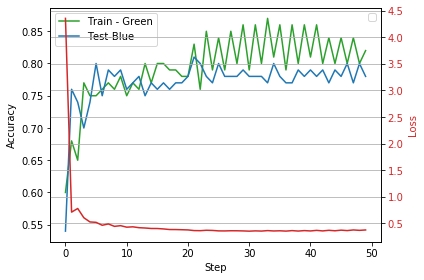

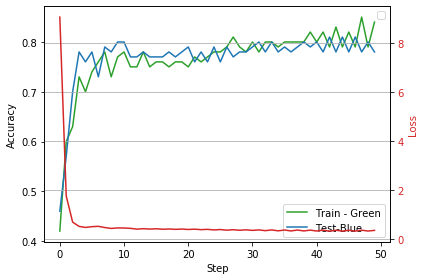

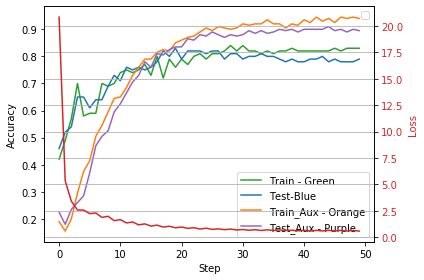

In [107]:
plot_train_info(train_info, False)
plot_train_info(train_info_WS, False)
plot_train_info(train_info_AL, True)

## Training

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.